Top 10 Handsets:
                    Handset Type  count
0              Huawei B528S-23A  19752
1       Apple iPhone 6S (A1688)   9419
2        Apple iPhone 6 (A1586)   9023
3                     undefined   8987
4        Apple iPhone 7 (A1778)   6326
5       Apple iPhone Se (A1723)   5187
6        Apple iPhone 8 (A1905)   4993
7       Apple iPhone Xr (A2105)   4568
8  Samsung Galaxy S8 (Sm-G950F)   4520
9        Apple iPhone X (A1901)   3813

Top 3 Manufacturers:
   Handset Manufacturer  count
0                Apple  59565
1              Samsung  40839
2               Huawei  34423

Top 5 Handsets per Manufacturer:
                Handset Manufacturer  \
0                            Huawei   
1                             Apple   
2                             Apple   
3                         undefined   
4                             Apple   
...                             ...   
1392                        Samsung   
1393     Dg Homtom Group Co Limited   
1394                    

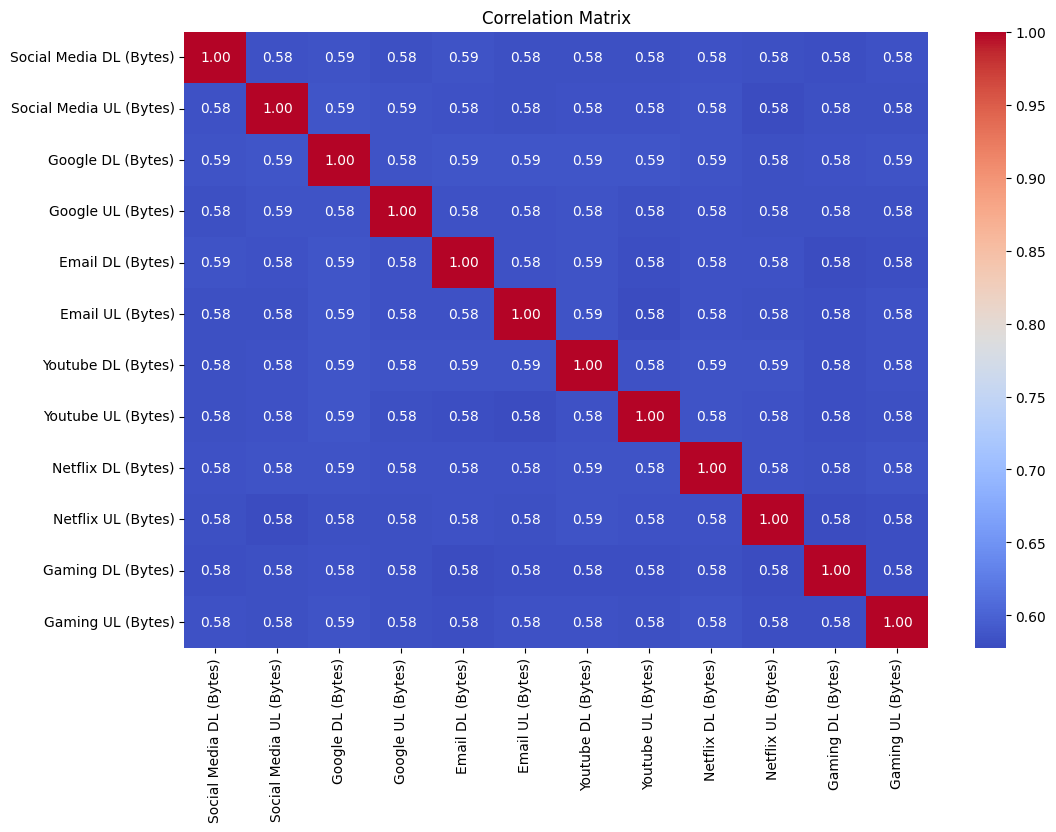


Explained Variance Ratio by PCA Components:
[0.61794054 0.03543368]


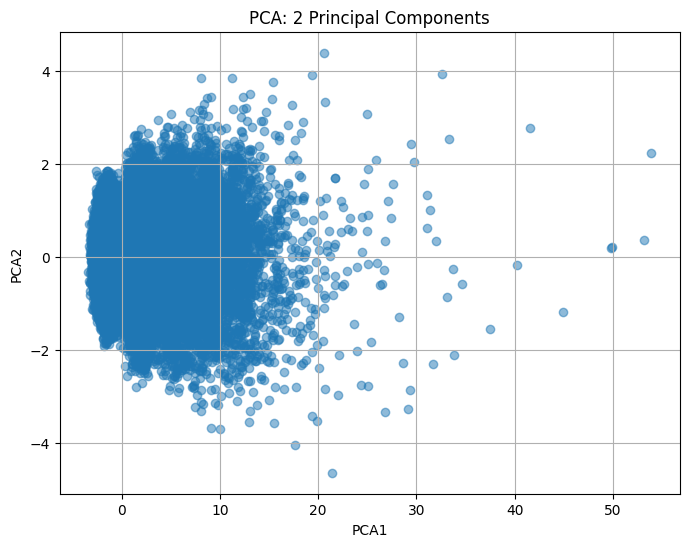

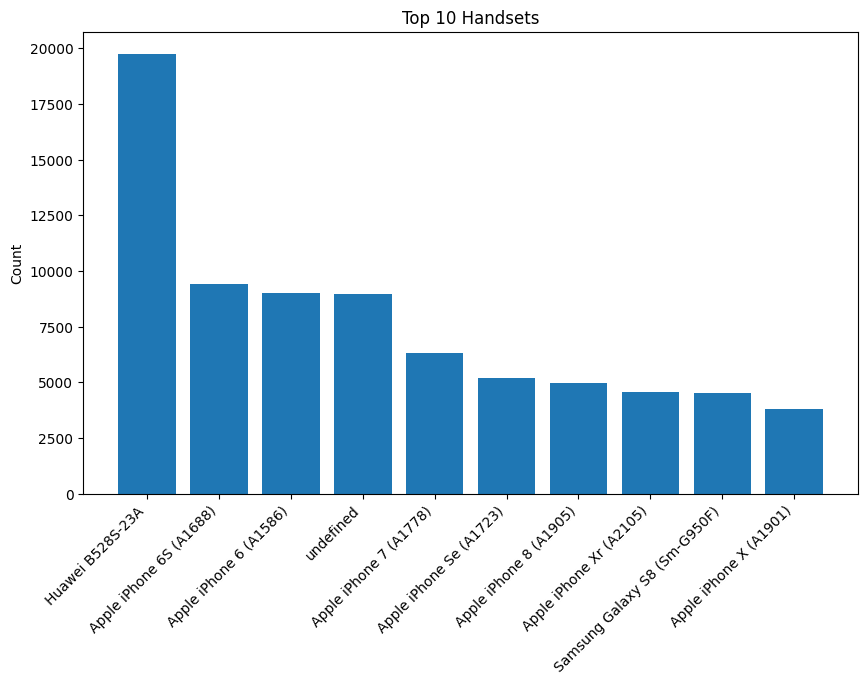

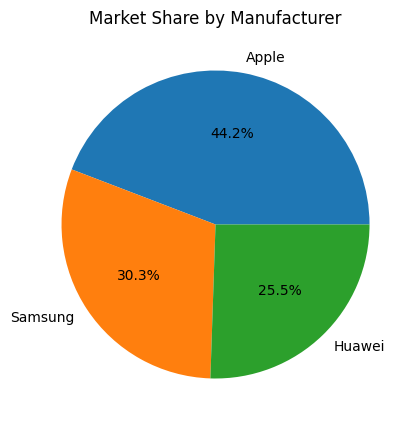

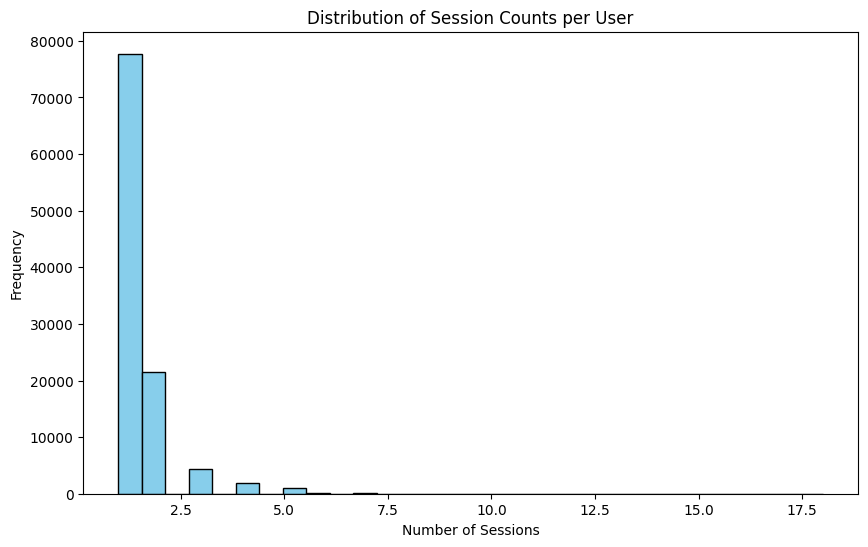

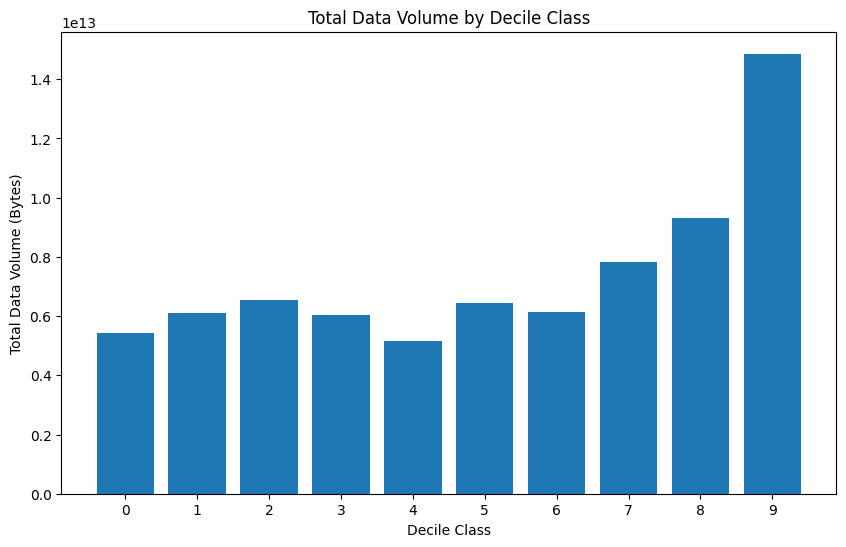

In [ ]:
from db_connection import fetch_data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Queries for handset and manufacturer analysis
QUERY_HANDSET = """
SELECT "Handset Type", COUNT(*) AS count
FROM xdr_data
GROUP BY "Handset Type"
ORDER BY count DESC
LIMIT 10;
"""

QUERY_MANUFACTURER = """
SELECT "Handset Manufacturer", COUNT(*) AS count
FROM xdr_data
GROUP BY "Handset Manufacturer"
ORDER BY count DESC
LIMIT 3;
"""

QUERY_TOP_HANDSETS = """
SELECT "Handset Manufacturer", "Handset Type", COUNT(*) AS count
FROM xdr_data
GROUP BY "Handset Manufacturer", "Handset Type"
ORDER BY count DESC;
"""

# Query for user aggregation
#QUERY_AGGREGATE_USERS = """
#SELECT "MSISDN/Number",
#       COUNT(*) AS session_count,
 #      SUM("Total UL (Bytes)") AS total_upload,
  #     SUM("Total DL (Bytes)") AS total_download,
   #    SUM("Dur. (ms)") AS total_duration
#FROM xdr_data
#GROUP BY "MSISDN/Number"
#ORDER BY session_count DESC;
#"""

QUERY_AGGREGATE_USERS = """
SELECT "MSISDN/Number",
       COUNT(*) AS session_count,
       SUM("Total UL (Bytes)") AS total_upload,
       SUM("Total DL (Bytes)") AS total_download,
       SUM("Dur. (ms)") AS total_duration,
       SUM("Social Media DL (Bytes)") AS "Social Media DL (Bytes)",
       SUM("Social Media UL (Bytes)") AS "Social Media UL (Bytes)",
       SUM("Google DL (Bytes)") AS "Google DL (Bytes)",
       SUM("Google UL (Bytes)") AS "Google UL (Bytes)",
       SUM("Email DL (Bytes)") AS "Email DL (Bytes)",
       SUM("Email UL (Bytes)") AS "Email UL (Bytes)",
       SUM("Youtube DL (Bytes)") AS "Youtube DL (Bytes)",
       SUM("Youtube UL (Bytes)") AS "Youtube UL (Bytes)",
       SUM("Netflix DL (Bytes)") AS "Netflix DL (Bytes)",
       SUM("Netflix UL (Bytes)") AS "Netflix UL (Bytes)",
       SUM("Gaming DL (Bytes)") AS "Gaming DL (Bytes)",
       SUM("Gaming UL (Bytes)") AS "Gaming UL (Bytes)"
FROM xdr_data
GROUP BY "MSISDN/Number"
ORDER BY session_count DESC;
"""


# Fetch data from DB for handsets
def load_handset_data():
    return fetch_data(QUERY_HANDSET)

# Fetch data from DB for manufacturers
def load_manufacturer_data():
    return fetch_data(QUERY_MANUFACTURER)

# Fetch top handsets per manufacturer
def load_top_handsets_per_manufacturer():
    return fetch_data(QUERY_TOP_HANDSETS)

# Fetch aggregated user data
def load_aggregated_user_data():
    return fetch_data(QUERY_AGGREGATE_USERS)

def clean_aggregated_data(df):
    # Drop rows where 'MSISDN/Number' is NaN
    df_cleaned = df.dropna(subset=["MSISDN/Number"])
    
    # Optionally, reset index
    df_cleaned.reset_index(drop=True, inplace=True)

    # Display summary after cleaning
    print(f"\nData after cleaning (NaN removed): {len(df_cleaned)} rows remaining")
    return df_cleaned

def visualize_data(handset_df, manufacturer_df, user_data):
    # Plot Top 10 Handsets
    plt.figure(figsize=(10, 6))
    plt.bar(handset_df['Handset Type'], handset_df['count'])
    plt.title('Top 10 Handsets')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Count')
    plt.show()

    # Plot Top 3 Manufacturers
    plt.figure(figsize=(8, 5))
    plt.pie(manufacturer_df['count'], labels=manufacturer_df['Handset Manufacturer'], autopct='%1.1f%%')
    plt.title('Market Share by Manufacturer')
    plt.show()

    # Plot User Engagement (Session Count Distribution)
    plt.figure(figsize=(10, 6))
    plt.hist(user_data['session_count'], bins=30, color='skyblue', edgecolor='black')
    plt.title('Distribution of Session Counts per User')
    plt.xlabel('Number of Sessions')
    plt.ylabel('Frequency')
    plt.show()


# EDA - Descriptive Statistics
def perform_eda(df):
    print("\nDescriptive Statistics (Aggregated User Data):")
    print(df.describe())

    # Check for missing values
    print("\nMissing Values in Aggregated Data:")
    print(df.isna().sum())
    
    # Outlier detection (using IQR for session count)
    Q1 = df['session_count'].quantile(0.25)
    Q3 = df['session_count'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df['session_count'] < (Q1 - 1.5 * IQR)) | (df['session_count'] > (Q3 + 1.5 * IQR))]
    
    print(f"\nNumber of Outliers (Session Count): {len(outliers)}")
    return df

def segment_users(df):
    # Compute total data volume
    df = df.copy()  # Avoid SettingWithCopyWarning
    df['total_data'] = df['total_upload'] + df['total_download']
    
    # Segment into deciles based on session duration
    df['decile_class'] = pd.qcut(df['total_duration'], 10, labels=False)
    
    # Aggregate total data per decile
    decile_agg = df.groupby('decile_class')['total_data'].sum().reset_index()
    
    print("\nTotal Data Volume per Decile Class:")
    print(decile_agg)
    return df, decile_agg


def visualize_segmentation(decile_agg):
    plt.figure(figsize=(10, 6))
    plt.bar(decile_agg['decile_class'], decile_agg['total_data'])
    plt.title('Total Data Volume by Decile Class')
    plt.xlabel('Decile Class')
    plt.ylabel('Total Data Volume (Bytes)')
    plt.xticks(decile_agg['decile_class'])
    plt.show()

# Correlation Analysis
def correlation_analysis(df):
    # Select relevant columns for correlation
    corr_columns = [
        "Social Media DL (Bytes)", "Social Media UL (Bytes)",
        "Google DL (Bytes)", "Google UL (Bytes)",
        "Email DL (Bytes)", "Email UL (Bytes)",
        "Youtube DL (Bytes)", "Youtube UL (Bytes)",
        "Netflix DL (Bytes)", "Netflix UL (Bytes)",
        "Gaming DL (Bytes)", "Gaming UL (Bytes)"
    ]
    
    # Compute correlation matrix
    correlation_matrix = df[corr_columns].corr()
    print("\nCorrelation Matrix:")
    print(correlation_matrix)
    
    # Visualize as a heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Correlation Matrix")
    plt.show()

def perform_pca(df):
    # Select numeric features for PCA
    pca_columns = [
        "Social Media DL (Bytes)", "Social Media UL (Bytes)",
        "Google DL (Bytes)", "Google UL (Bytes)",
        "Email DL (Bytes)", "Email UL (Bytes)",
        "Youtube DL (Bytes)", "Youtube UL (Bytes)",
        "Netflix DL (Bytes)", "Netflix UL (Bytes)",
        "Gaming DL (Bytes)", "Gaming UL (Bytes)"
    ]
    
    # Standardize data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[pca_columns].fillna(0))
    
    # Perform PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_data)
    
    # Create a copy before modifying
    df = df.copy()
    df.loc[:, 'PCA1'] = pca_result[:, 0]
    df.loc[:, 'PCA2'] = pca_result[:, 1]
    
    print("\nExplained Variance Ratio by PCA Components:")
    print(pca.explained_variance_ratio_)
    
    # Scatter plot of PCA results
    plt.figure(figsize=(8, 6))
    plt.scatter(df['PCA1'], df['PCA2'], alpha=0.5)
    plt.title("PCA: 2 Principal Components")
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.grid()
    plt.show()
    
    return df




if __name__ == "__main__":
    # Handset Analysis
    print("Top 10 Handsets:\n", load_handset_data())
    print("\nTop 3 Manufacturers:\n", load_manufacturer_data())
    print("\nTop 5 Handsets per Manufacturer:\n", load_top_handsets_per_manufacturer())

    # User Data Aggregation
    user_data = load_aggregated_user_data()
    print("\nAggregated User Data:\n", user_data.head(10))  # Display top 10 results
 
   # Handset and Manufacturer Analysis
    top_handsets = load_handset_data()
    top_manufacturers = load_manufacturer_data()
    top_per_manufacturer = load_top_handsets_per_manufacturer()
    
    # User Data Aggregation
    user_data = load_aggregated_user_data()
    
    # Data Cleaning
    user_data_cleaned = clean_aggregated_data(user_data)
    
    # Perform EDA
    user_data_eda = perform_eda(user_data_cleaned)
    
    # Segment Users into Deciles
    segmented_data, decile_aggregation = segment_users(user_data_eda)

    # Correlation Analysis
    correlation_analysis(user_data_cleaned)
    
    # Perform PCA
    segmented_data = perform_pca(user_data_cleaned)
    
    # Visualization
    visualize_data(top_handsets, top_manufacturers, segmented_data)
    visualize_segmentation(decile_aggregation)